# Topic/User Analysis

## Load Data

In [1]:
import pandas as pd
import numpy as np

chosen_dataset = 'cop26_tweets_en'
chosen_dataset = 'covid_tweets_en'
chosen_dataset = 'ukraine_tweets_en'
ur_df = pd.read_parquet('./../../data/raw/'+chosen_dataset+'.parquet')
doc_info = pd.read_csv('./../../data/processed/document_info_'+chosen_dataset+'.csv')[['Document', 'Topic', 'Representative_document','Name']]
doc_info.Topic = doc_info.Topic.astype(int)
embeddings = np.load('./../../data/processed/'+chosen_dataset+'.parquet.npy')

In [2]:
print(doc_info.columns)

Index(['Document', 'Topic', 'Representative_document', 'Name'], dtype='object')


## Merge dataset
Merge Topic data with Tweets so that (retweets are included).

In [3]:
# merge ur_df with doc_info on 'text'
merged_df = ur_df.merge(doc_info, left_on='text', right_on='Document', how='left')
assert len(merged_df) == len(ur_df), 'differing length before and after merge, duplicates in right'

In [4]:
ur_df.columns

Index(['id', 'author_id', 'created_at', 'lang', 'in_reply_to_user_id',
       'conversation_id', 'text', 'reply_settings', 'possibly_sensitive',
       'retweeted_id', 'quoted_id', 'replied_id', 'url', 'expanded_url',
       'mention_name', 'hashtags', 'retweet_count', 'reply_count',
       'like_count', 'quote_count', 'username', 'individual_or_org',
       'category'],
      dtype='object')

## Assign Topic to Users
Group topics by users, and assign using a threshold 

In [5]:
# Function to select dominant topics
from collections import Counter

def get_user_frequent_topic(topics, threshold=0.5, exclude=-1):
    """
    Args:
        topics (list): list of topic labels for a user.
        threshold (float): minimum fraction (e.g., 0.5 for 50%) for frequence.
        exclude (int or list): topic(s) to exclude, e.g. -1 for bertopic Noise.
    
    Returns:
        int or None: dominant topic if above threshold, else None
    """
    if isinstance(exclude, int):
        topics = [t for t in topics if t != exclude]
    elif isinstance(exclude, list):
        topics = [t for t in topics if t not in exclude]

    if not topics:
        return None

    total = len(topics)
    topic_counts = Counter(topics)
    top_topic, top_count = topic_counts.most_common(1)[0]
    
    if top_count / total >= threshold:
        return int(top_topic)
    return None


### Using Entropy to assign topics
If we want to assign topics unambigously to all users, we can use entropy to assign them.

We assign a topic only if entropy of the user's topic distribution is low, i.e., user is focused.
To do so, we compute entropy of users' topic distributions, excluding noise (topic -1).

Then, we prevent the assignment of topics in the presence of ties.

| Entropy | Interpretation                                             |
| ------- | ---------------------------------------------------------- |
| 0       | All tweets in one topic (perfect focus)                    |
| \~1     | Tweets mostly in 2 topics                                  |
| \~2     | Tweets across 4 topics fairly evenly                       |
| \~3     | Tweets across \~8 topics                                   |
| \~4     | Tweets across \~16 topics                                  |
| ...     | ... (upper limit is $\log_2(N)$, where $N$ = total topics) |


In [6]:
# Function to select dominant topic using entropy to theshold it.
from scipy.stats import entropy
#from collections import Counter
import numpy as np
from math import log2


def get_user_dominant_topic(topics, max_entropy=log2(3), exclude=-1):
    """
    Args:
        topics (list): list of topic labels for a user.
        max_entropy (float): maximum allowed entropy. If user's topic distribution exceeds this, no dominant topic is assigned.
        exclude (int or list): topic(s) to exclude, e.g. -1 for noise.
    
    Returns:
        int or None: dominant topic if above threshold, else None
    """
    if isinstance(exclude, int):
        topics = [t for t in topics if t != exclude]
    elif isinstance(exclude, list):
        topics = [t for t in topics if t not in exclude]

    if not topics:
        return None

    topic_counts = Counter(topics)
    topic_probs = np.array(list(topic_counts.values())) / len(topics)
    
    most_common = topic_counts.most_common(2)
    if len(most_common)>1 and most_common[0][1] == most_common[1][1]:
        return None

    top_topic, _ = most_common[0]
    
    if entropy(topic_probs) < max_entropy:
        return int(top_topic)
    return None

topic_test = [0,0,0,0,0,0,2,2,2,2,2,1,1,1,3,4,5]
test_topic_counts = Counter(topic_test)

print(f"most common topic: {get_user_dominant_topic(topic_test)}")

most common topic: 0


In [7]:
def topic_entropy(topics, exclude = -1):

    if isinstance(exclude, int):
        topics = [t for t in topics if t != exclude]
    elif isinstance(exclude, list):
        topics = [t for t in topics if t not in exclude]
    if not topics:
        return None
        
    counts = Counter(topics)
    probs = np.array(list(counts.values())) / len(topics)
    return entropy(probs)

Confront user retention using different thresholds

In [8]:
def Log2(x):
    return round(log2(x), 2)

user_topics = merged_df.groupby('author_id')['Topic'].apply(list)

# Compute entropy of topic distributions among users.
user_topic_entropy = user_topics.apply(lambda topics: topic_entropy(topics))

# try with log₂(2)=1 max entropy
user_dominant_topic_1 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, max_entropy=log2(2)))

# try with log₂(3) max entropy
user_dominant_topic_1_5 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, max_entropy=log2(3)))

# Try with log₂(4)=2 max entropy
user_dominant_topic_2 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, max_entropy=log2(4)))

# Try with log₂(6) max entropy
user_dominant_topic_2_3 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, max_entropy=log2(5)))

# Try with log₂(5) max entropy
user_dominant_topic_2_5 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, max_entropy=log2(6)))

# Try with log₂(8)=3 max entropy
user_dominant_topic_3 = user_topics.apply(lambda topics: get_user_dominant_topic(topics, max_entropy=log2(8)))

# Combine into a DataFrame for comparison
result = pd.DataFrame({
    'topic_entropy' : user_topic_entropy,
    'effective_topic_number':np.exp2(user_topic_entropy),
    'dominant_topic_2': user_dominant_topic_1,
    'dominant_topic_3':user_dominant_topic_1_5,
    'dominant_topic_4': user_dominant_topic_2,
    'dominant_topic_5':user_dominant_topic_2_3,
    'dominant_topic_6':user_dominant_topic_2_5,
    'dominant_topic_8': user_dominant_topic_3
})

print(f"NaN with H<{Log2(2)=} max entropy:\t{float(round(result.dominant_topic_2.isna().sum()/len(result), 2)*100)}%")
print(f"NaN with H<{Log2(3)=} max entropy:\t{float(round(result.dominant_topic_3.isna().sum()/len(result), 2)*100)}%")
print(f"NaN with H<{Log2(4)=} max entropy:\t{float(round(result.dominant_topic_4.isna().sum()/len(result), 2)*100)}%")
print(f"NaN with H<{Log2(5)=} max entropy:\t{float(round(result.dominant_topic_5.isna().sum()/len(result), 2)*100)}%")
print(f"NaN with H<{Log2(6)=} max entropy:\t{float(round(result.dominant_topic_6.isna().sum()/len(result), 2)*100)}%")
print(f"NaN with H<{Log2(8)=} max entropy:\t{float(round(result.dominant_topic_8.isna().sum()/len(result), 2)*100)}%")

NaN with H<Log2(2)=1.0 max entropy:	98.0%
NaN with H<Log2(3)=1.58 max entropy:	97.0%
NaN with H<Log2(4)=2.0 max entropy:	96.0%
NaN with H<Log2(5)=2.32 max entropy:	92.0%
NaN with H<Log2(6)=2.58 max entropy:	89.0%
NaN with H<Log2(8)=3.0 max entropy:	80.0%


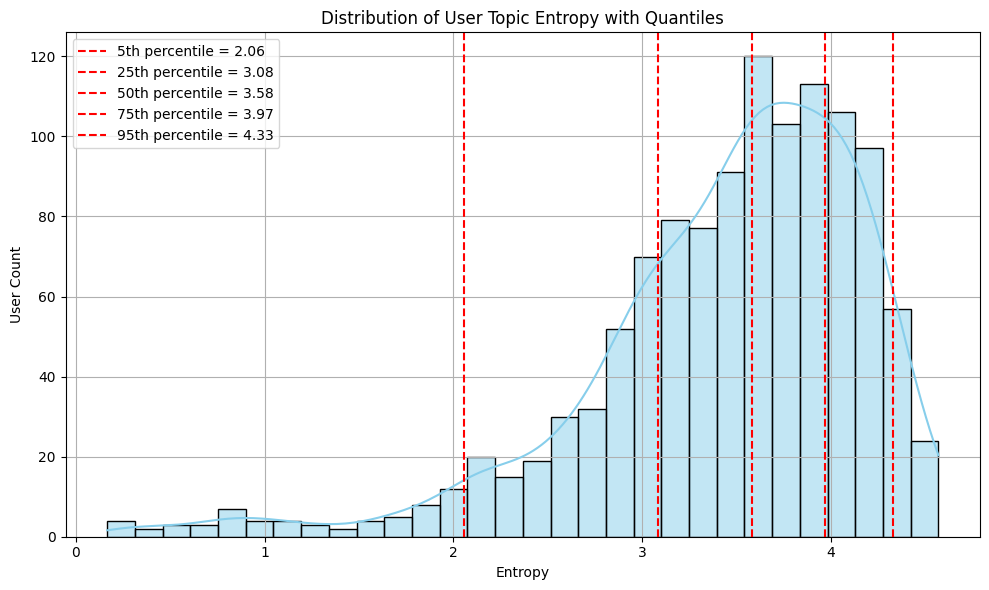

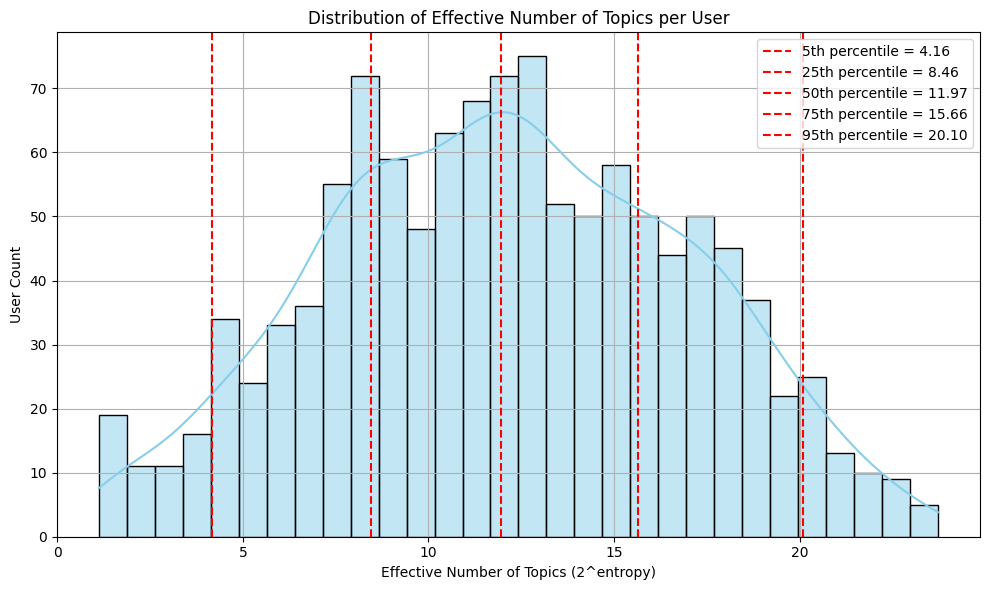

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_entropy_distribution(entropy_series, bins=30, quantiles=[0.05, 0.25, 0.5, 0.75, 0.95]):
    """
    Plot the distribution of entropy values from a pandas Series with quantile lines.
    
    Args:
        entropy_series (pd.Series): Entropy values per user.
        bins (int): Number of bins for histogram.
        quantiles (list): List of quantile values to plot (e.g., [0.25, 0.5, 0.75]).
    """
    entropy_series = entropy_series.dropna()
    q_values = entropy_series.quantile(quantiles)

    plt.figure(figsize=(10, 6))
    sns.histplot(entropy_series, bins=bins, kde=True, color='skyblue', edgecolor='black')

    for q, val in zip(quantiles, q_values):
        plt.axvline(x=val, color='red', linestyle='--', linewidth=1.5, label=f'{int(q*100)}th percentile = {val:.2f}')

    # Remove duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title("Distribution of User Topic Entropy with Quantiles")
    plt.xlabel("Entropy")
    plt.ylabel("User Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_entropy_distribution(user_topic_entropy)

def plot_effective_topic_count(entropy_series, bins=30, quantiles=[0.05, 0.25, 0.5, 0.75, 0.95]):
    """
    Plot distribution of effective number of topics (2^entropy) with quantile lines.
    
    Args:
        entropy_series (pd.Series): Entropy values per user.
        bins (int): Number of bins in histogram.
        quantiles (list): Quantile values to annotate.
    """
    entropy_series = entropy_series.dropna()
    effective_topics = np.exp2(entropy_series)
    q_values = effective_topics.quantile(quantiles)

    plt.figure(figsize=(10, 6))
    sns.histplot(effective_topics, bins=bins, kde=True, color='skyblue', edgecolor='black')

    for q, val in zip(quantiles, q_values):
        plt.axvline(x=val, color='red', linestyle='--', linewidth=1.5, label=f'{int(q*100)}th percentile = {val:.2f}')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title("Distribution of Effective Number of Topics per User")
    plt.xlabel("Effective Number of Topics (2^entropy)")
    plt.ylabel("User Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_effective_topic_count(user_topic_entropy)

In [10]:
for r in user_topics.iloc[np.where(user_topic_entropy > 3)]:
    r = np.array(r)
    if len(r[np.where(r!=-1)])>0:
        
        print(Counter(r[np.where(r!=-1)]))

Counter({np.int64(4): 24, np.int64(0): 9, np.int64(2): 7, np.int64(56): 6, np.int64(9): 5, np.int64(25): 5, np.int64(33): 4, np.int64(7): 3, np.int64(3): 3, np.int64(15): 3, np.int64(8): 3, np.int64(62): 3, np.int64(80): 3, np.int64(1): 3, np.int64(158): 2, np.int64(32): 2, np.int64(10): 2, np.int64(45): 1, np.int64(135): 1, np.int64(29): 1, np.int64(93): 1, np.int64(75): 1, np.int64(165): 1, np.int64(39): 1, np.int64(43): 1, np.int64(14): 1, np.int64(127): 1, np.int64(13): 1, np.int64(58): 1, np.int64(149): 1, np.int64(94): 1, np.int64(28): 1, np.int64(12): 1, np.int64(52): 1, np.int64(101): 1, np.int64(6): 1, np.int64(164): 1, np.int64(97): 1, np.int64(154): 1, np.int64(19): 1, np.int64(88): 1})
Counter({np.int64(2): 36, np.int64(18): 35, np.int64(27): 35, np.int64(1): 34, np.int64(3): 19, np.int64(0): 17, np.int64(63): 17, np.int64(39): 17, np.int64(23): 14, np.int64(17): 13, np.int64(5): 13, np.int64(94): 12, np.int64(16): 12, np.int64(21): 12, np.int64(9): 12, np.int64(30): 12, np

In [15]:

# Try with 30% threshold
user_dominant_topic_30 = user_topics.apply(lambda topics: get_user_frequent_topic(topics, threshold=0.3))

# Try with 50% threshold
user_dominant_topic_50 = user_topics.apply(lambda topics: get_user_frequent_topic(topics, threshold=0.5))

# Try with 60% threshold
user_dominant_topic_60 = user_topics.apply(lambda topics: get_user_frequent_topic(topics, threshold=0.6))

# Combine into a DataFrame for comparison
result['dominant_topic_30'] = user_dominant_topic_30
result['dominant_topic_50'] = user_dominant_topic_50
result['dominant_topic_60'] = user_dominant_topic_60

print("Verify how many users have a defined value")
print(f"NaN with 30% threshold:\t{float(round(result.dominant_topic_30.isna().sum()/len(result), 2)*100)}%")
print(f"NaN with 50% threshold:\t{float(round(result.dominant_topic_50.isna().sum()/len(result), 2)*100)}%")
print(f"NaN with 60% threshold:\t{float(round(result.dominant_topic_60.isna().sum()/len(result), 2)*100)}%")

Verify how many users have a defined value
NaN with 30% threshold:	90.0%
NaN with 50% threshold:	95.0%
NaN with 60% threshold:	97.0%


Topics are floats because some topics are NaN
Will eliminate NaN and convert dtype to int when final results will be added

## Combine with user metadata
Load metadata and explore results

In [23]:
# `user_metadata` is a DataFrame with columns like:
# 'id', 'individual_or_org', 'category'
if chosen_dataset == 'cop26_tweet_en':
    user_metadata = pd.read_csv("./../../data/raw/influencers_summary_cop26.csv")
elif chosen_dataset == 'covid_tweets_en':
    user_metadata = pd.read_csv("./../../data/raw/influencers_summary_covid.csv")
elif chosen_dataset == 'ukraine_tweets_en':
    user_metadata = pd.read_csv("./../../data/raw/influencers_summary_ru_ukr.csv")
#print(f"{result.index.dtype}")
user_metadata.id = user_metadata.id.astype(str)
print(f"{user_metadata['id'].dtype=}")
user_metadata.columns

user_metadata['id'].dtype=dtype('O')


Index(['id', 'username', 'individual_or_org', 'category', 'num_of_rt',
       'num_original_tweets', 'followers_count', 'num_of_retweeters'],
      dtype='object')

In [24]:
# Merge with user-topic assignments from previous step
combined_df = user_metadata.merge(result, left_on='id', right_on='author_id')

Use crosstabs and grouped bar plots to explore distributions.

In [25]:
pd.crosstab(combined_df['individual_or_org'], combined_df['dominant_topic_50'], normalize='index')

dominant_topic_50,1.0,2.0,6.0,7.0,8.0,9.0,10.0,15.0,18.0,19.0,...,57.0,63.0,64.0,65.0,87.0,110.0,112.0,125.0,131.0,158.0
individual_or_org,,,,,,,,,,,,,,,,,,,,,
Individual,0.000000,0.032258,0.129032,0.032258,0.032258,0.000000,0.000000,0.000000,0.032258,0.032258,...,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.064516,0.000000,0.000000,0.000000
Organization,0.363636,0.000000,0.045455,0.000000,0.000000,0.045455,0.090909,0.045455,0.000000,0.045455,...,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.045455,0.045455,0.045455


In [26]:
pd.crosstab(combined_df['category'], combined_df['dominant_topic_50'], normalize='index')

dominant_topic_50,1.0,2.0,6.0,7.0,8.0,9.0,10.0,15.0,18.0,19.0,...,57.0,63.0,64.0,65.0,87.0,110.0,112.0,125.0,131.0,158.0
category,,,,,,,,,,,,,,,,,,,,,
Activist,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000,0.5,0.000000,0.000000,0.25,0.000000,0.000000,0.000,0.0
International Organization / NGO,0.600000,0.000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,...,0.000000,0.000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.1
Media,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.125,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.125,0.0
Other,0.000000,0.000,0.444444,0.000000,0.000000,0.000000,0.0,0.111111,0.000000,0.000000,...,0.000000,0.000,0.0,0.000000,0.000000,0.00,0.000000,0.111111,0.000,0.0
Politics,0.285714,0.000,0.000000,0.000000,0.000000,0.142857,0.0,0.000000,0.000000,0.142857,...,0.000000,0.000,0.0,0.000000,0.000000,0.00,0.142857,0.000000,0.000,0.0
Private Individual,0.000000,0.000,0.066667,0.066667,0.066667,0.000000,0.0,0.000000,0.066667,0.066667,...,0.066667,0.000,0.0,0.066667,0.066667,0.00,0.066667,0.000000,0.000,0.0


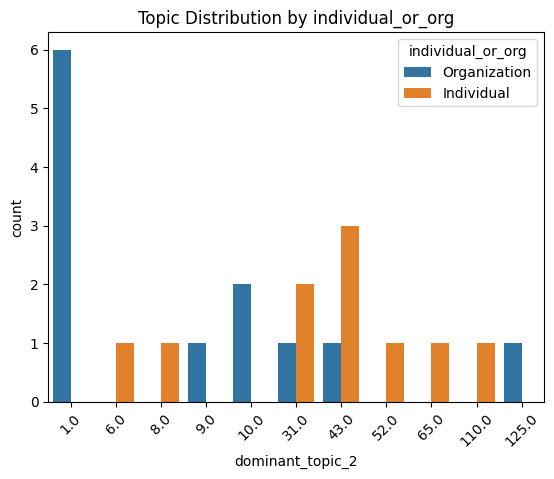

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=combined_df, x='dominant_topic_2', hue='individual_or_org')
plt.title("Topic Distribution by individual_or_org")
plt.xticks(rotation=45)
plt.show()

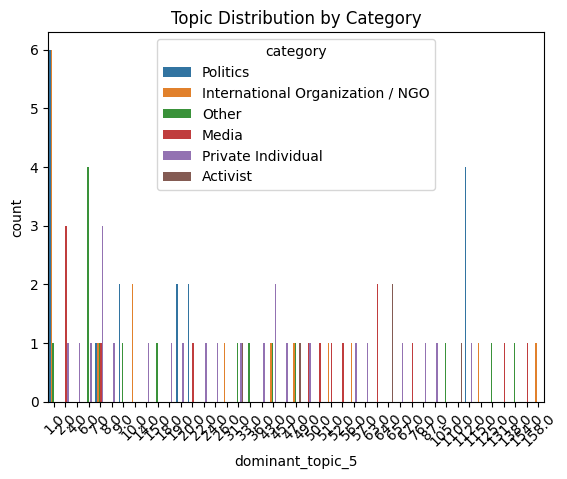

In [28]:


sns.countplot(data=combined_df, x='dominant_topic_5', hue='category')
plt.title("Topic Distribution by Category")
plt.xticks(rotation=45)
plt.show()


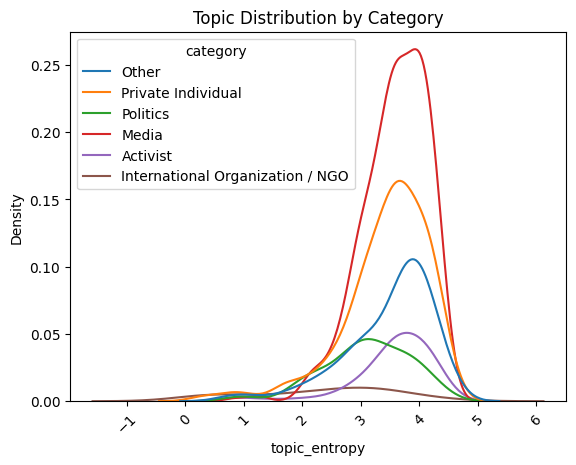

In [29]:
sns.kdeplot(data=combined_df, x='topic_entropy', hue='category')
plt.title("Topic Distribution by Category")
plt.xticks(rotation=45)
plt.show()

## Statistical Test for Association
### Chi²
Use Chi² for categorical association, and Cramer's V
Low p-value (e.g. < 0.05) → strong evidence that topic assignment and political leaning are not independent.
### Cramer's V 
Interpretation of effect size

|Effect size (ES) | Interpretation|
| --------- | --------- |
|ES ≤ 0.2	| The result is weak. Although the result is statistically significant, the fields are only weakly associated.|
|0.2 < ES ≤ 0.6	| The result is moderate. The fields are moderately associated.|
|ES > 0.6	| The result is strong. The fields are strongly associated.|


### Individual or Organization

In [32]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(combined_df['individual_or_org'], combined_df['dominant_topic_2'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}, p-value: {p}")


Chi-square statistic: 16.28611111111111, p-value: 0.09172983731240171


In [33]:
import numpy as np

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

cramers_v(contingency_table)


np.float64(0.8603939666093537)

### Category

In [38]:
contingency_table = pd.crosstab(combined_df['category'], combined_df['dominant_topic_2'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}, p-value: {p}")


Chi-square statistic: 72.64583333333331, p-value: 0.019876994850654344


In [39]:
import numpy as np

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

cramers_v(contingency_table)


np.float64(0.8126602406089931)